In [1]:
# sound_classification 가상환경으로 진행
import matlab
import matlab.engine
import numpy as np
import os
import torchaudio
import librosa
import torch
import matplotlib.pyplot as plt
from utility import *
import IPython.display as ipd
from IPython.display import Audio
import pandas as pd

## Sound Data Class

In [2]:

class SoundProperty:
    def __init__(self, filepath, label, folder, sound_name):
        print('label: {}, sound source: {}, file name: {}'.format(label, folder, sound_name))
        self.label = label
        self.folder = folder
        self.sound_name = sound_name
        self.sound_path = os.path.join(filepath, label, folder, sound_name)
        print('sound path: {}'.format(self.sound_path))
            
        self.converted_peak_list = None
        self.peak_list = None
        self.energy_list = None
        self.loudness_list = None
        
        self.onset_times = None
        self.onset_times = None
        self.onset_strengths = None
        
        self.sound = None
        self.sr = None
        # self.type = None
        
    def load_sound(self, sampling_rate=44100):
        sound, sr = torchaudio.load(self.sound_path)
        if sound.shape[0] == 2:
            sound = torch.mean(sound, dim=0).view(1, -1)
            sound = sound[0]
        if sr != sampling_rate:
            sound = torchaudio.functional.resample(sound, orig_freq=sr, new_freq=sampling_rate)
            sr = sampling_rate
        sound = sound.numpy()
        self.sound = sound.reshape(-1)
        self.sr = sr
    
    def calculate_energy_loudness(self, eng, type=1):
        matlab_dict = eng.AudioEnergyLoudnessPython(self.sound_path, self.sr)
        self.converted_peak_list =  np.asarray(matlab_dict[0])
        self.peak_list = np.asarray(matlab_dict[1])
        self.energy_list =  np.asarray(matlab_dict[2]).reshape(-1)
        self.loudness_list =  np.asarray(matlab_dict[3]).reshape(-1)
                
    def onset_sound(self, hop_length=5, n_mels=16):
            
        # hop_length = int(hop_length * self.sr / 1000)
        # window_size = int(hop_length * 2)

        if len(self.sound) > self.sr * 10:
            y = center_crop(self.sound, len(self.sound)//4)
        else:
            y = self.sound
        
        # D = np.abs(librosa.stft(y, n_fft=window_size, win_length = window_size, hop_length=hop_length, center=False))
        # mel_spec = librosa.feature.melspectrogram(S=D, sr=self.sr, n_mels=n_mels, hop_length=hop_length, win_length=window_size)
        # amplitude = librosa.amplitude_to_db(mel_spec, ref=1.0)
        # self.onset_strengths = librosa.onset.onset_strength(sr=self.sr, S=amplitude) # onset strength
        # self.onset_frames = librosa.onset.onset_detect(onset_envelope=self.onset_strengths, sr=self.sr, hop_length=hop_length) # onset detection
        # self.onset_times = librosa.times_like(self.onset_strengths, sr=self.sr, hop_length=hop_length) # onset times
        self.onset_strengths = librosa.onset.onset_strength(y=y, sr=self.sr)
        self.onset_frames = librosa.onset.onset_detect(onset_envelope=self.onset_strengths, sr=self.sr)
        self.onset_times = librosa.times_like(self.onset_strengths, sr=self.sr)

    def plot_properties(self):
        plt.figure(figsize=(7, 10))
        plt.subplot(4, 1, 1)
        plt.title('Sound waveform / Energy / Loudness')
        plt.plot(torch.arange(0, len(self.sound)) / self.sr, self.sound)
        # plt.gca().axes.xaxis.set_visible(False)
        plt.legend(["waveform"])
        plt.subplot(4, 1, 2)
        plt.plot(self.onset_times, self.onset_strengths)
        plt.vlines(self.onset_times[self.onset_frames], 0, self.onset_strengths.max(), color='r', alpha=0.9,
                        linestyle='--', label='Onsets')
        plt.legend(["onset strength", "onsets"])
        plt.gca().axes.xaxis.set_visible(False)
        plt.subplot(4, 1, 3)
        plt.plot(torch.arange(0, len(self.energy_list)) / 100,  self.energy_list)
        plt.vlines(self.peak_list[:, 0] / 100, 0, max(self.energy_list), color='r', alpha=0.9,
                linestyle='--', label='Onsets')
        plt.gca().axes.xaxis.set_visible(False)
        plt.legend(["energy", "energy peaks"])
        plt.subplot(4, 1, 4)
        plt.plot(torch.arange(0, len(self.loudness_list)) / 2000,  self.loudness_list)
        plt.vlines(self.peak_list[:, 1] / 2000, 0, max(self.loudness_list), color='r', alpha=0.9,
                linestyle='--', label='Onsets')
        plt.legend(["loudness", "loudness peaks"])
        plt.show()
        
    def play_sound(self):
        ipd.display(Audio(self.sound, rate=self.sr))

## Load File Path

In [3]:
filepath = os.path.join('.', 'dataset', 'Fighting')
label_name = os.listdir(filepath)

filepath_list = []
label_list = []
folder_list = []
sound_name_list = []

for label in label_name:
    folder_name = os.listdir(os.path.join(filepath, label))
    for folder in folder_name:
        file_name = os.listdir(os.path.join(filepath, label, folder))
        for sound_name in file_name: 
            filepath_list.append(filepath)
            label_list.append(label)
            folder_list.append(folder)
            sound_name_list.append(sound_name)
            
df = pd.DataFrame({
    'filepath' : filepath_list,
    'label' : label_list,
    'folder' : folder_list,
    'sound_name' : sound_name_list
}, columns=['filepath', 'label', 'folder', 'sound_name'])
df_attack = df.loc[df['label'] == 'attack']
df_crowd = df.loc[df['label'] == 'crowd']

In [4]:
df_attack.head()

,filepath,label,folder,sound_name
0,.\dataset\Fighting,attack,Artlist,Alberto Sueri - RPG Game - Energetic Punch .wav
1,.\dataset\Fighting,attack,Artlist,Bjorn Lynne - Hits and Swooshes - Low End Punc...
2,.\dataset\Fighting,attack,Artlist,BOOM Library - Physical Combat - Hard Hitting ...
3,.\dataset\Fighting,attack,Artlist,"BOOM Library - Physical Combat - Punch, Heavy,..."
4,.\dataset\Fighting,attack,Artlist,BOOM Library - Physical Combat - Short Tight P...


### matlab start

In [5]:
eng = matlab.engine.start_matlab()

------------------------------------------------------------------------------------
i = 7
label: attack, sound source: Artlist, file name: Echoto Sound - Boxing - Single Punch.wav
sound path: .\dataset\Fighting\attack\Artlist\Echoto Sound - Boxing - Single Punch.wav


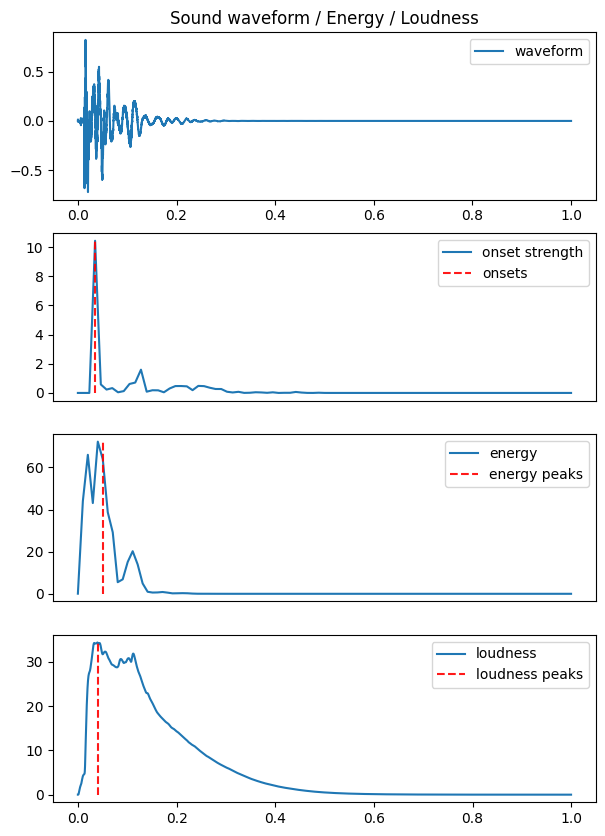

------------------------------------------------------------------------------------
------------------------------------------------------------------------------------
i = 8
label: attack, sound source: Artlist, file name: Fly Sound - Military Action - Thumping Hits, Foley Punches.wav
sound path: .\dataset\Fighting\attack\Artlist\Fly Sound - Military Action - Thumping Hits, Foley Punches.wav


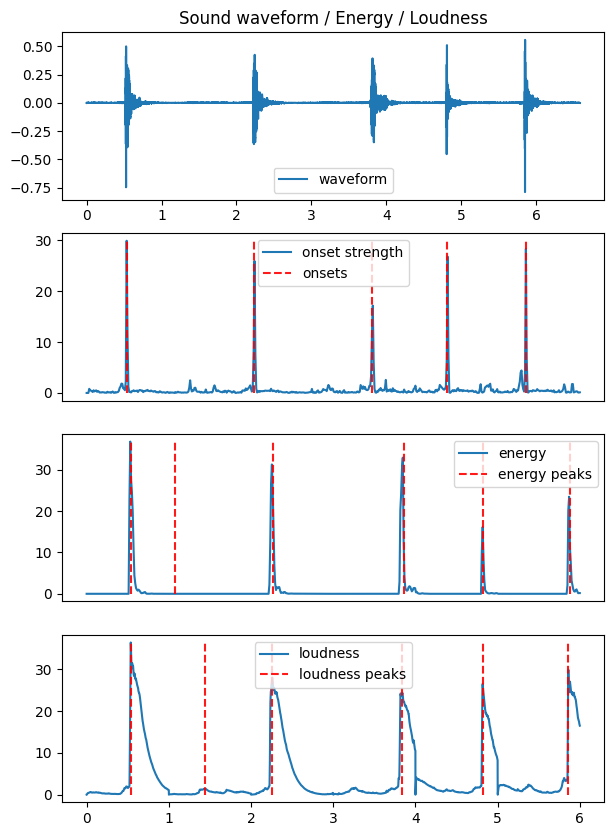

------------------------------------------------------------------------------------
------------------------------------------------------------------------------------
i = 9
label: attack, sound source: Artlist, file name: Gamemaster Audio - Close Combat - Punch, Blow to the Body.wav
sound path: .\dataset\Fighting\attack\Artlist\Gamemaster Audio - Close Combat - Punch, Blow to the Body.wav


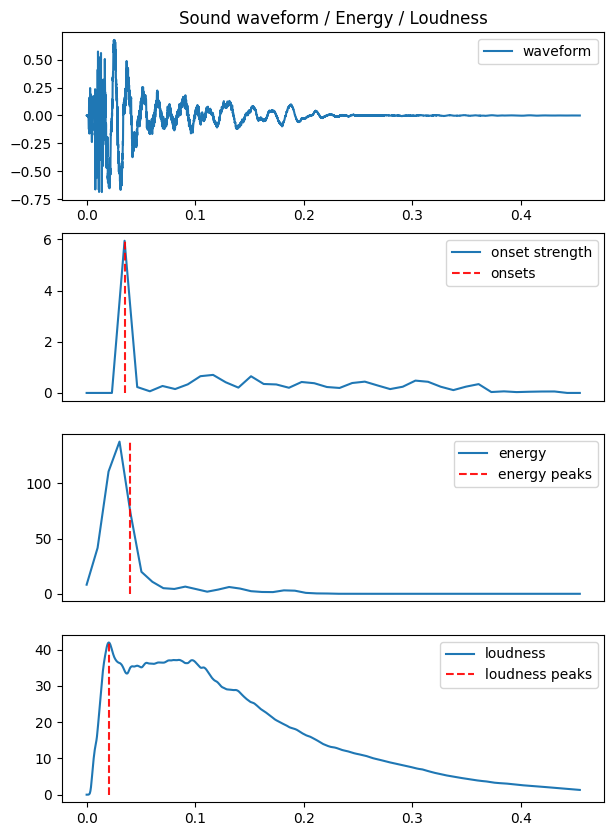

------------------------------------------------------------------------------------


KeyboardInterrupt: Interrupted by user

In [6]:
for i in range(7, len(label_list)):
    print('------------------------------------------------------------------------------------')
    print('i = {}'.format(i)
          )
    sampling_rate = 44100
    filepath = df_crowd.iloc[i]['filepath']
    label = df_attack.iloc[i]['label']
    folder = df_attack.iloc[i]['folder']
    sound_name = df_attack.iloc[i]['sound_name']
    
    soud_property = SoundProperty(filepath, label, folder, sound_name)
    soud_property.load_sound(sampling_rate=sampling_rate)
    soud_property.calculate_energy_loudness(eng)
    soud_property.concat_segment()
    soud_property.onset_sound(hop_length=20, n_mels=16)
    soud_property.plot_properties()
    soud_property.play_sound()
    print('------------------------------------------------------------------------------------')
    _ = input()

### 디버깅 용

In [ ]:
j = 8
sampling_rate = 44100
filepath = df_crowd.iloc[j]['filepath']
label = df_attack.iloc[j]['label']
folder = df_attack.iloc[j]['folder']
sound_name = df_attack.iloc[j]['sound_name']

soud_property = SoundProperty(filepath, label, folder, sound_name)
soud_property.load_sound(sampling_rate=sampling_rate)
soud_property.calculate_energy_loudness(eng)
soud_property.concat_segment()